In [2]:
!pip install --upgrade transformers
#Libraries
import numpy as np
import pandas as pd
import re

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Word Cloud library
from wordcloud import WordCloud, STOPWORDS

# Library used for data preprocessing
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import AutoTokenizer

# Model selection libraries
from sklearn.model_selection import train_test_split

# Library used for ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
dataset = load_dataset("bourigue/data_email_spam")
print(dataset)

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spam_email_dataset.csv:   0%|          | 0.00/112M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/85782 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_combined', 'label'],
        num_rows: 85782
    })
})


In [4]:
df = dataset['train'].to_pandas()
df.head()

,text_combined,label
0,fark rssfeedsspamassassintaintorg url httpwwwn...,0
1,alamac thanks painful got contract says 5 busi...,0
2,daily top 10 tanneryteunion104tnet daily top 1...,1
3,liza everett linpillardmetpillardde po dh ren ...,1
4,czanikhotmailcom font face3dverdana size3d3 co...,1


In [5]:
print(f"Dataset loaded: {len(df)} samples")
print(f"Class distribution:\n{df['label'].value_counts()}\n")

Dataset loaded: 85782 samples
Class distribution:
label
0    42891
1    42891
Name: count, dtype: int64



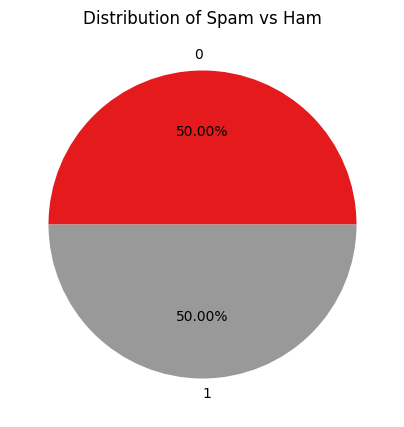

In [6]:
import matplotlib.pyplot as plt

# Label distribution
spread = df['label'].value_counts()

# Pie chart
plt.rcParams['figure.figsize'] = (5, 5)
spread.plot(kind='pie', autopct='%1.2f%%', cmap='Set1')
plt.title('Distribution of Spam vs Ham')
plt.ylabel('')
plt.show()

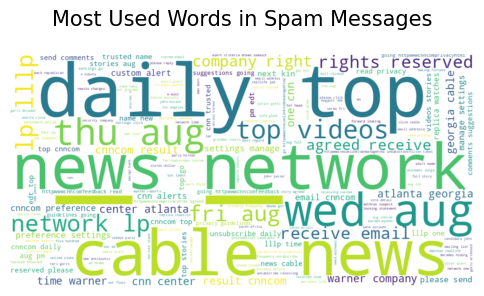

In [7]:
df_spam = df[df['label'] == 1]
stopwords = set(STOPWORDS)
text = " ".join(df_spam['text_combined'].astype(str).tolist()).lower()

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords=stopwords,
    max_words=1000
).generate(text)

plt.figure(figsize=(6, 6))
plt.title("Most Used Words in Spam Messages", fontsize=15, pad=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'max_length': 128,
    'train_split': 0.7,
    'val_split': 0.1,
    'test_split': 0.2,
    'seed': 42
}

# Normalization:

def normalize_text(text):
    #Normalizing and cleaning email text while preserving spam indicators

    if pd.isna(text):
        return ""

    text = str(text)

    #Lowercase
    text = text.lower()

    #Normalize repeated characters (such as "oooo " or "eeeee")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    #Normalize numbers and replace with NUMBER token
    text = re.sub(r'\d+', ' NUMBER ', text)

    #Normalize currency symbols
    text = re.sub(r'[$£€¥₹]', ' CURRENCY ', text)

    #Replace URLs with URL token
    text = re.sub(r'http\S+|www\.\S+', ' URL ', text)

    #Replace email addresses with EMAIL token
    text = re.sub(r'\S+@\S+', ' EMAIL ', text)

    #Normalize excessive punctuation
    text = re.sub(r'!{2,}', ' EXCLAMATION ', text)
    text = re.sub(r'\?{2,}', ' QUESTION ', text)

    #Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    #Remove special characters
    text = re.sub(r'[^\w\s!?$]', ' ', text)

    #Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    #Remove very short texts
    if len(text) < 10:
        return ""

    return text

df['text_combined'] = df['text_combined'].apply(normalize_text)

# Remove empty texts after normalization
df = df[df['text_combined'].str.len() > 0].reset_index(drop=True)
print(f"Normalization complete: {len(df)} samples remaining")

Normalization complete: 85777 samples remaining


In [9]:
#Test set:
train_val_df, test_df = train_test_split(
    df,
    test_size=CONFIG['test_split'],
    random_state=CONFIG['seed'],
    stratify=df['label']
)

#Validation set from training set:
val_size = CONFIG['val_split'] / (CONFIG['train_split'] + CONFIG['val_split'])
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    random_state=CONFIG['seed'],
    stratify=train_val_df['label']
)

print(f" Train set: {len(train_df)} samples")
print(f"  - Ham: {(train_df['label']==0).sum()}, Spam: {(train_df['label']==1).sum()}")
print(f" Validation set: {len(val_df)} samples")
print(f"  - Ham: {(val_df['label']==0).sum()}, Spam: {(val_df['label']==1).sum()}")
print(f" Test set: {len(test_df)} samples")
print(f"  - Ham: {(test_df['label']==0).sum()}, Spam: {(test_df['label']==1).sum()}")

 Train set: 60043 samples
  - Ham: 30023, Spam: 30020
 Validation set: 8578 samples
  - Ham: 4289, Spam: 4289
 Test set: 17156 samples
  - Ham: 8579, Spam: 8577


In [10]:
def tokenize_function(examples):

    tokens = tokenizer(
        examples['text_combined'],
        max_length=CONFIG['max_length'],
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    tokens['labels'] = examples['label']
    return tokens

tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

train_dataset = Dataset.from_pandas(train_df[['text_combined', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text_combined', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text_combined', 'label']])

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['text_combined', 'label'])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['text_combined', 'label'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['text_combined', 'label'])

#Final Dataset:
final_dataset = DatasetDict({'train': tokenized_train, 'validation': tokenized_val,'test': tokenized_test})

print(final_dataset)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/60043 [00:00<?, ? examples/s]

Map:   0%|          | 0/8578 [00:00<?, ? examples/s]

Map:   0%|          | 0/17156 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 60043
    })
    validation: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8578
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 17156
    })
})


In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
final_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs"
)

In [14]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

In [16]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [17]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zarchiphyo091 (zarchiphyo091-concordia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.199200
1000,0.113300
1500,0.080000
2000,0.076900
2500,0.064600
3000,0.054200
3500,0.057200
4000,0.039700
4500,0.027800
5000,0.026400


TrainOutput(global_step=11259, training_loss=0.04029366691388439, metrics={'train_runtime': 4648.6857, 'train_samples_per_second': 38.748, 'train_steps_per_second': 2.422, 'total_flos': 1.184848282273536e+16, 'train_loss': 0.04029366691388439, 'epoch': 3.0})

In [18]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.05438808724284172, 'eval_accuracy': 0.9922476101655398, 'eval_f1': 0.992240826089493, 'eval_runtime': 118.387, 'eval_samples_per_second': 144.915, 'eval_steps_per_second': 9.063, 'epoch': 3.0}


              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      8579
        spam       0.99      0.99      0.99      8577

    accuracy                           0.99     17156
   macro avg       0.99      0.99      0.99     17156
weighted avg       0.99      0.99      0.99     17156



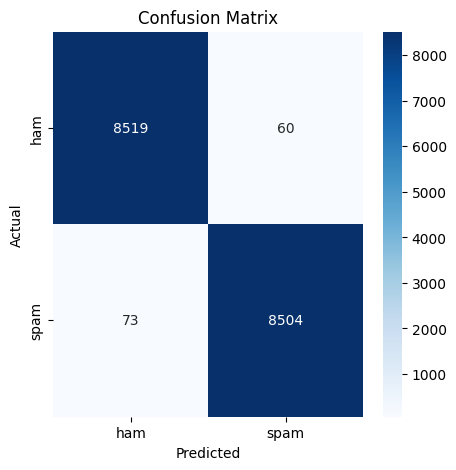

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
predictions = trainer.predict(final_dataset["test"])

# Extract predicted and true labels
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=["ham", "spam"]))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
model.save_pretrained("./bert")
tokenizer.save_pretrained("./tokenizer")

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.txt',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

In [21]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
final_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [23]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./distilbert_results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./distilbert_logs"
)

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss
500,0.176500
1000,0.090200
1500,0.062800
2000,0.056700
2500,0.053100
3000,0.039700
3500,0.046600
4000,0.027800


Step,Training Loss
500,0.176500
1000,0.090200
1500,0.062800
2000,0.056700
2500,0.053100
3000,0.039700
3500,0.046600
4000,0.027800
4500,0.015200
5000,0.020700


TrainOutput(global_step=11259, training_loss=0.03027104776349666, metrics={'train_runtime': 2284.2134, 'train_samples_per_second': 78.858, 'train_steps_per_second': 4.929, 'total_flos': 5965305013126656.0, 'train_loss': 0.03027104776349666, 'epoch': 3.0})

In [26]:
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.05330701917409897, 'eval_accuracy': 0.9922476101655398, 'eval_f1': 0.9922453501253571, 'eval_runtime': 60.6586, 'eval_samples_per_second': 282.829, 'eval_steps_per_second': 17.689, 'epoch': 3.0}


In [ ]:
model.save_pretrained("./distilbert_model")
tokenizer.save_pretrained("./distilbert_model_tokenizer")

In [28]:
import numpy as np
import pandas as pd

predictions = trainer.predict(final_dataset["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

df_predictions = pd.DataFrame({
    "true_label": true_labels,
    "predicted_label": predicted_labels
})
df_predictions.to_csv("distilbert_predictions.csv", index=False)

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      8579
        spam       0.99      0.99      0.99      8577

    accuracy                           0.99     17156
   macro avg       0.99      0.99      0.99     17156
weighted avg       0.99      0.99      0.99     17156



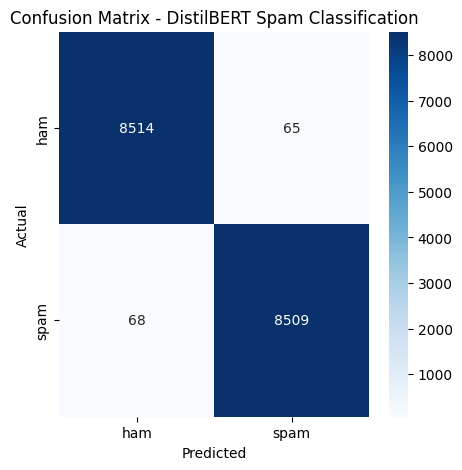

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(true_labels, predicted_labels, target_names=["ham", "spam"]))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DistilBERT Spam Classification")
plt.show()